<a href="https://colab.research.google.com/github/Hrithik2212/Neural-Machine-Translation--English-to-Tamil/blob/main/01_NMT_English_to_Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation English to Tamil

In [ ]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F

## Dataset

In [ ]:
eng_file = '/content/drive/MyDrive/en-ta/train.en'
tamil_file = '/content/drive/MyDrive/en-ta/train.ta'

### The dataset consists of a total of 5.2 million sentencs in english translated to tamil

In [ ]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(tamil_file, 'r') as file:
    tamil_sentences = file.readlines()


english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
tamil_sentences = [sentence.rstrip('\n') for sentence in tamil_sentences]

In [ ]:
# Create an empty set to store characters
vocabulary = set()

# Iterate through each text sample and extract characters
for text in tamil_sentences[:10000]:
    # Convert the text to Unicode code points (characters)
    characters = [char for char in text]
    vocabulary.update(characters)  # Add characters to the vocabulary set

# Convert the set back to a list and sort it
sorted_vocab = sorted(list(vocabulary))

# Print the sorted vocabulary
print(" ".join(sorted_vocab))


  ! " $ % & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : < = > ? @ A B C D E F G H I J K L M N O P Q R S T U V W X Y Z [ \ ] _ ` a b c d e f g h i j k l m n o p q r s t u v w x y z { | }   ­ ° · » ÷ ø ü ń Б В С Э а б в г д е ж и й л н о р с т э я ү । ஃ அ ஆ இ ஈ உ ஊ எ ஏ ஐ ஒ ஓ க ங ச ஜ ஞ ட ண த ந ன ப ம ய ர ற ல ள ழ வ ஷ ஸ ஹ ா ி ீ ு ூ ெ ே ை ொ ோ ௌ ் ​ ‌ ‍ – — ‘ ’ “ ” • … ′ ⁠ ₹ → ⇔ ≠ ≤ □ ▪ ◆ ﻿


In [ ]:
# Create an empty set to store characters
vocabulary = set()

# Iterate through each text sample and extract characters
for text in english_sentences[:10000]:
    # Convert the text to Unicode code points (characters)
    characters = [char for char in text]
    vocabulary.update(characters)  # Add characters to the vocabulary set

# Convert the set back to a list and sort it
sorted_vocab = sorted(list(vocabulary))

# Print the sorted vocabulary
print(" ".join(sorted_vocab))

  ! " # $ % & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : < = > ? @ [ \ ] _ ` a b c d e f g h i j k l m n o p q r s t u v w x y z { | }


In [ ]:
START_TOKEN = 'S'
PADDING_TOKEN = 'P'
END_TOKEN = 'E'

# Got the tamil vocab by from the above output
tamil_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ',
                      "ஃ", "அ", "ஆ", "இ", "ஈ", "உ", "ஊ", "எ", "ஏ", "ஐ", "ஒ", "ஓ", "ஔ",
                      "க", "ங", "ச", "ஜ", "ஞ", "ட", "ண",
                      "த", "ந", "ன", "ப", "ம", "ய", "ர",
                      "ற", "ல", "ள", "ழ", "வ", "ஶ", "ஷ", "ஸ", "ஹ",
                      "ா", "ி", "ீ", "ு", "ூ", "ெ", "ே", "ை", "ொ", "ோ", "ௌ", "்", "ௗ",
                      "௦", "௧", "௨", "௫", "௬", "௲", "௳"
                      , PADDING_TOKEN, END_TOKEN]

english_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]

In [ ]:
ta_vocab_size = len(tamil_vocabulary)
en_vocab_size = len(english_vocabulary)

In [ ]:
## Mapping
index_to_tamil = {k:v for k,v in enumerate(tamil_vocabulary)}
tamil_to_index = {v:k for k,v in enumerate(tamil_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [ ]:
import numpy as np
PERCENTILE = 97
print( f"{PERCENTILE}th percentile length Tamil: {np.percentile([len(x) for x in tamil_sentences], PERCENTILE)}" )
print( f"{PERCENTILE}th percentile length English: {np.percentile([len(x) for x in english_sentences], PERCENTILE)}" )


97th percentile length Tamil: 239.0
97th percentile length English: 216.0


In [ ]:

max_sequence_length = 220
min_sequence_length = 3

def is_valid_tokens(sentence , vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def is_valid_length(sentence, max_sequence_length , min_sequence_length):
    return len(list(sentence)) < (max_sequence_length - 1) and len(list(sentence)) > min_sequence_length + 1  # need to re-add the eos and bos

valid_sentence_indicies = []
for index in range(len(english_sentences[:1000000])):
    tamil_sentence, english_sentence = tamil_sentences[index], english_sentences[index]
    if is_valid_length(english_sentence, max_sequence_length , min_sequence_length)  \
      and is_valid_length(tamil_sentence, max_sequence_length ,min_sequence_length) \
      and is_valid_tokens(tamil_sentence, tamil_vocabulary) \
      and is_valid_tokens(english_sentence , english_vocabulary):
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(tamil_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of sentences: 5264867
Number of valid sentences: 850916


In [ ]:
TOTAL_SENTENCES = 200000 # lets take 200000 valid sentences to train the model
english_sentences = [english_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]
tamil_sentences = [tamil_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]

In [ ]:
len(english_sentences) , len(tamil_sentences)

(200000, 200000)

In [ ]:
dataset = list(zip(english_sentences , tamil_sentences))

In [ ]:
dataset[123]

('more males than females kill themselves.',
 'பெண்களை விட, ஆண்களே அதிகம் தற்கொலை செய்து கொள்கின்றனர்.')

In [ ]:
type(dataset)

list

In [ ]:
max(len(x) for x in tamil_sentences), max(len(x) for x in english_sentences),

(218, 218)

# **Transformer Archirtecture**
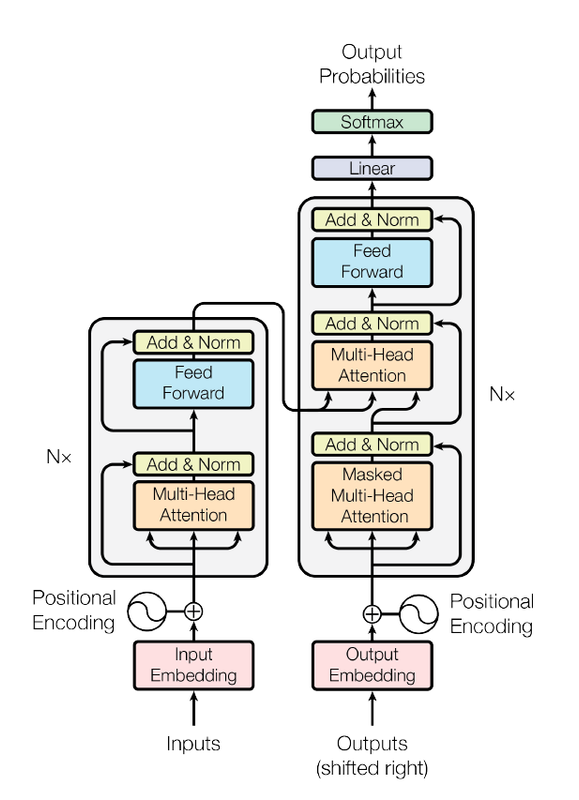

In [ ]:
def get_device():
  return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
get_device()

device(type='cuda')

### Self-Attention

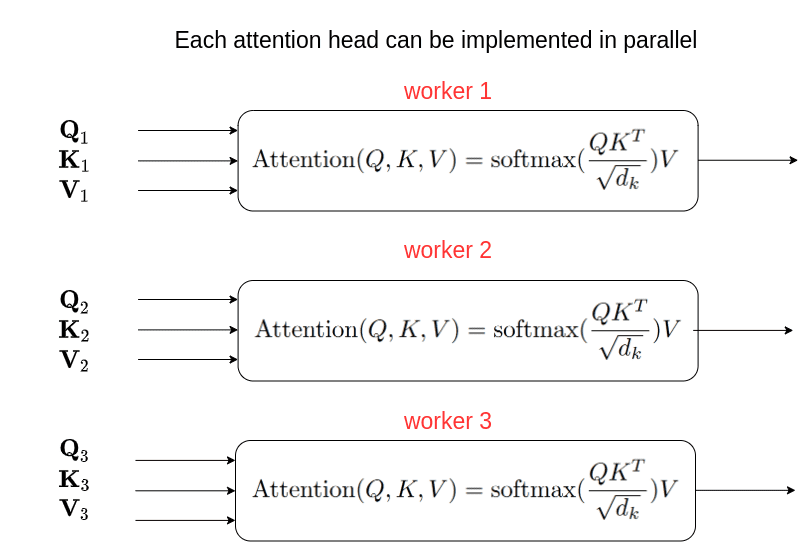



In [ ]:

def Attention(q , k , v  , mask = None ):
  d_k = q.size()[-1]
  scaled = torch.matmul(q , k.transpose(-1,-2)) / math.sqrt(d_k)
  if mask is not None:
    scaled = scaled.permute(1,0,2,3) + mask
    scaled = scaled.permute(1,0,2,3)
  attention = F.softmax(scaled , dim=1)
  values = torch.matmul(attention ,v)
  return values , attention

### Positional Encoding

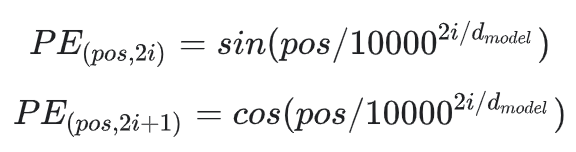

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self , d_model ,  max_sequence_length)->None:
    super().__init__()
    self.d_model = d_model
    self.max_sequence_length = max_sequence_length

  def forward(self ):
    even_i = torch.arange(0,self.d_model,2).float()
    denominator = torch.pow(10000 , even_i / self.d_model )
    positions = (torch.arange(self.max_sequence_length).reshape(self.max_sequence_length , 1))
    even_pos = torch.sin(positions / denominator )
    odd_pos = torch.cos(positions / denominator )
    positional_encoding = torch.stack([even_pos , odd_pos],dim=2)
    positional_encoding = torch.flatten(positional_encoding ,start_dim = 1 ,end_dim=2)
    return positional_encoding


In [ ]:
# class SentenceEmbedding(nn.Module):
#   def __init__(self , max_sequence_length , d_model , lang_to_index, START_TOKEN , END_TOKEN , PADDING_TOKEN ):
#     super().__init__()
#     self.vocab_size = len(lang_to_index)
#     self.max_sequence_length = max_sequence_length
#     self.d_model = d_model
#     self.lang_to_index = lang_to_index
#     self.embedding = nn.Embedding(self.vocab_size , d_model )
#     self.positional_encoder = PositionalEncoding(self.d_model ,self.max_sequence_length)
#     self.START_TOKEN = START_TOKEN
#     self.END_TOKEN = END_TOKEN
#     self.PADDING_TOKEN = PADDING_TOKEN
#     self.dropout = nn.Dropout(p=0.1)

#     # def tokenize(sentence , start_token , end_token ):
#     #   sentence_word_indices = [self.lang_to_index[tok] for tok in list(sentence)]
#     #   if start_token :
#     #     sentence_word_indices.insert(0,self.lang_to_index[self.START_TOKEN])
#     #   if end_token :
#     #     sentence_word_indices.append(self.lang_to_index[self.END_TOKEN])

#     #   for _ in range(len(sentence_word_indices),self.max_sequence_length):
#     #     sentence_word_indices.append(self.lang_to_index[self.PADDING_TOKEN])
#     #   return torch.tensor(sentence_word_indices)

#     # tokenized = []
#     # for sentence_num in range(len(batch)):
#     #   tokenized.append(tokenize(batch[sentence_num],start_token ,end_token))
#     # tokenized = torch.stack(tokenized)
#     # return tokenized.to(get_device())
#   def batch_tokenize(self, batch, start_token, end_token):
#       tokenized = []
#       for sentence_num in range(len(batch)):
#         tokenized.append(self.tokenize(batch[sentence_num], start_token, end_token))

#     # Pad the sentences to the maximum sequence length
#       padded_tokenized = torch.nn.utils.rnn.pad_sequence(tokenized, batch_first=True, padding_value=self.lang_to_index[self.PADDING_TOKEN])

#       return padded_tokenized.to(get_device())


#   def forward(self , x , start_token , end_token  )->None:
#     x = self.batch_tokenize(x , start_token , end_token )
#     x = self.embedding(x)
#     pos = self.positional_encoder().to(get_device())
#     x = self.dropout(x+pos)
#     return x

class SentenceEmbedding(nn.Module):
    def __init__(self, max_sequence_length, d_model, lang_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(lang_to_index)
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model
        self.lang_to_index = lang_to_index
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.positional_encoder = PositionalEncoding(self.d_model, self.max_sequence_length)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN
        self.dropout = nn.Dropout(p=0.1)

    def tokenize(self, sentence, start_token, end_token):
        sentence_word_indices = [self.lang_to_index[tok] for tok in list(sentence)]
        if start_token:
            sentence_word_indices.insert(0, self.lang_to_index[self.START_TOKEN])
        if end_token:
            sentence_word_indices.append(self.lang_to_index[self.END_TOKEN])

        for _ in range(len(sentence_word_indices), self.max_sequence_length):
            sentence_word_indices.append(self.lang_to_index[self.PADDING_TOKEN])
        return torch.tensor(sentence_word_indices)

    def batch_tokenize(self, batch, start_token, end_token):
        tokenized = []
        for sentence_num in range(len(batch)):
            tokenized.append(self.tokenize(batch[sentence_num], start_token, end_token))

        # Pad the sentences to the maximum sequence length
        padded_tokenized = torch.nn.utils.rnn.pad_sequence(tokenized, batch_first=True, padding_value=self.lang_to_index[self.PADDING_TOKEN])
        # tokenized = torch.stack(tokenized)
        return padded_tokenized.to(get_device())

    def forward(self, x, start_token, end_token):
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        pos = self.positional_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x


### Multi-Head-Attention
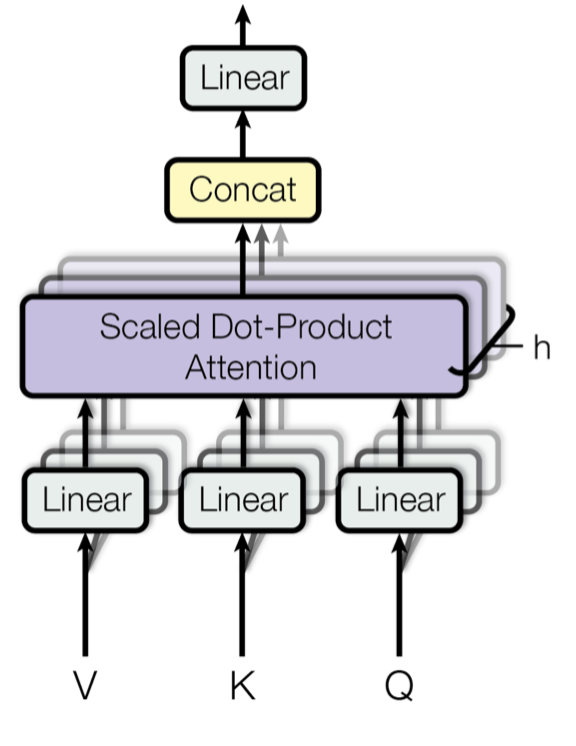

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self , d_model , num_heads ):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(d_model , 3*d_model)
    self.Linear_layer = nn.Linear(d_model , d_model )

  def forward(self , x , mask):
    batch_size , sequence_length , d_model = x.size()
    qkv = self.qkv_layer(x)
    qkv = qkv.reshape(batch_size , sequence_length , self.num_heads , 3*self.head_dim)
    qkv = qkv.permute(0,2,1,3)
    q , k , v = qkv.chunk(3,dim=-1)
    values , attention = Attention(q,k,v,mask)
    values = values.permute(0,2,1,3).reshape(batch_size , sequence_length , self.num_heads*self.head_dim)
    out = self.Linear_layer(values)
    return out

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self , parameters_shape , eps=1e-5):
    super().__init__()
    self.parameters_shape = parameters_shape
    self.eps = eps
    self.gamma = nn.Parameter(torch.ones(parameters_shape))
    self.beta = nn.Parameter(torch.zeros(parameters_shape))

  def forward(self , inputs):
    dims = [-(i+1) for i in range(len(self.parameters_shape))]
    mean = inputs.mean(dim=dims,keepdim=True)
    var = ((inputs - mean)**2).mean(dim=dims , keepdim= True)
    std = (var+self.eps).sqrt()
    y = (inputs-mean )/std
    out = self.gamma * y + self.beta
    return out

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self , d_model , hidden , drop_prob=0.1):
    super(PositionwiseFeedForward , self ).__init__()
    self.linear_1 = nn.Linear(d_model , hidden)
    self.linear_2 = nn.Linear(hidden , d_model )
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=drop_prob)

  def forward(self , x ):
    x = self.linear_1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear_2(x)
    return x

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self  , d_model ,ffn_hidden , num_heads , drop_prob ):
    super(EncoderLayer , self).__init__()
    self.attention = MultiHeadAttention(d_model = d_model , num_heads = num_heads)
    self.norm1 = LayerNormalization(parameters_shape = [d_model] )
    self.dropout1 = nn.Dropout(p=drop_prob)
    self.ffn = PositionwiseFeedForward(d_model , ffn_hidden , drop_prob)
    self.norm2 = LayerNormalization(parameters_shape = [d_model])
    self.dropout2 = nn.Dropout(p=drop_prob)

  def forward(self , x , self_attention_mask):
    x_residual = x.clone()
    x = self.attention(x , mask=self_attention_mask)
    x = self.dropout1(x)
    x = self.norm1(x + x_residual)
    x_residual = x.clone()
    x = self.ffn(x)
    x = self.dropout2(x)
    x = self.norm2(x + x_residual)
    return x

In [ ]:
# class SequentialEncoder(nn.Sequential):
#   def forward(self , *inputs ):
#     x , self_attention_mask = inputs
#     for module in self.modules.values():
#       x = module(x , self_attention_mask )
#     return x

class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask = inputs
        for module in self:
            x = module(x, self_attention_mask)
        return x


### Muli-Layer-Encoder
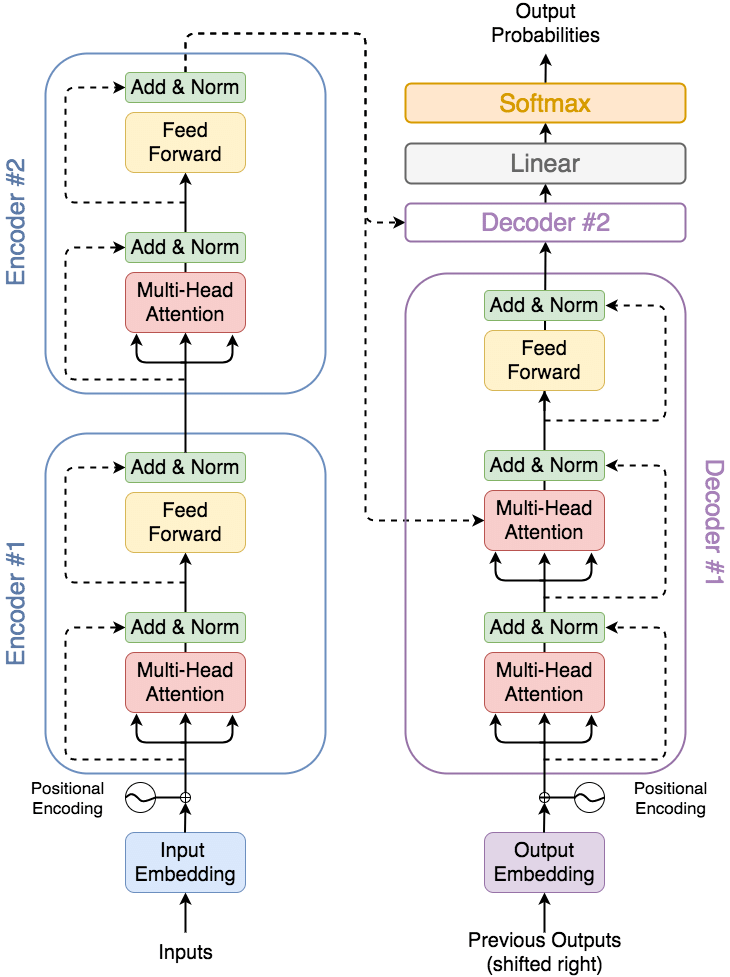

In [ ]:
class Encoder(nn.Module):
  def __init__(self ,
               d_model ,
               ffn_hidden ,
               num_heads ,
               drop_prob ,
               num_layers ,
               max_sequence_length ,
               lang_to_index ,
               START_TOKEN ,
               END_TOKEN ,
               PADDING_TOKEN ):
    super().__init__()
    self.sentence_embedding = SentenceEmbedding(max_sequence_length ,
                                                d_model ,lang_to_index,
                                                START_TOKEN ,
                                                END_TOKEN ,
                                                PADDING_TOKEN)
    self.layers = SequentialEncoder(*[
                                  EncoderLayer(d_model , ffn_hidden , num_heads , drop_prob)
                                  for _ in range(num_layers)])

  def forward(self , x , self_attention_mask , start_token , end_token ):
    x = self.sentence_embedding(x , start_token , end_token)
    x = self.layers(x , self_attention_mask)
    return x

### Multi-Head Cross Attention
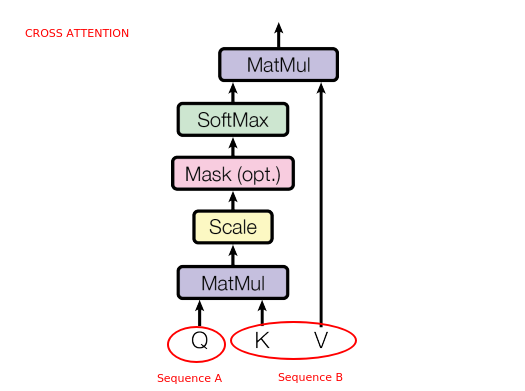

In [ ]:
class MultiHeadCrossAttention(nn.Module):
  def __init__(self , d_model , num_heads):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.kv_layer = nn.Linear(d_model , 2*d_model )
    self.q_layer = nn.Linear(d_model , d_model)
    self.linear_layer = nn.Linear(d_model , d_model)

  def forward(self, x , y , mask ):
    batch_size , sequence_length , d_model = x.size()
    # print(f'Xshape - {x.shape , x.size}')
    # print(f'Yshape - {y.shape}')
    kv = self.kv_layer(x)
    q = self.q_layer(y)
    # print(f"Head Dim : {self.head_dim}")
    kv = kv.reshape(batch_size , sequence_length , self.num_heads , 2*self.head_dim )
    q = q.reshape(batch_size , sequence_length , self.num_heads , self.head_dim )
    kv = kv.permute(0,2,1,3)
    q = q.permute(0,2,1,3)
    k , v = kv.chunk(2 , dim=-1 )
    values , attention = Attention(q,k,v , mask )
    values = values.permute(0,2,1,3).reshape(batch_size , sequence_length , d_model )
    out = self.linear_layer(values)
    return out

### Multi Layer Decoder

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self , d_model , ffn_hidden , num_heads , drop_prob ):
    super(DecoderLayer ,self).__init__()
    self.self_attention = MultiHeadAttention(d_model , num_heads)
    self.norm1 = LayerNormalization(parameters_shape = [d_model])
    self.dropout1 = nn.Dropout(p=drop_prob)

    self.encoder_decoder_attention = MultiHeadCrossAttention(d_model , num_heads)
    self.norm2 = LayerNormalization(parameters_shape=[d_model])
    self.dropout2 = nn.Dropout(p=drop_prob)

    self.ffn = PositionwiseFeedForward(d_model , ffn_hidden , drop_prob = drop_prob)
    self.norm3 = LayerNormalization(parameters_shape=[d_model])
    self.dropout3 = nn.Dropout(p=drop_prob)

  def forward(self , x  , y , self_attention_mask , cross_attention_mask ):
    y_residual = y.clone()
    y = self.self_attention(y , self_attention_mask)
    y = self.dropout1(y)
    y = self.norm1(y + y_residual)

    y_residual = y.clone()
    y = self.encoder_decoder_attention(x , y , cross_attention_mask)
    y = self.dropout2(y)
    y = self.norm2(y+y_residual)

    y_residual = y.clone()
    y = self.ffn(y)
    y = self.dropout3(y)
    y = self.norm3(y+y_residual)
    return y



In [ ]:
class SequentialDecoder(nn.Sequential):
  def forward(self , *inputs):
    x , y , self_attention_mask , cross_attention_mask = inputs
    for module in self:
      y = module(x , y , self_attention_mask , cross_attention_mask )
    return y

In [ ]:
class Decoder(nn.Module):
  def __init__(self ,
               d_model ,
               ffn_hidden ,
               num_heads ,
               num_layers ,
               drop_prob  ,
               max_sequence_length ,
               lang_to_index ,
               START_TOKEN ,
               END_TOKEN ,
               PADDING_TOKEN ):
    super().__init__()
    self.sentence_embedding = SentenceEmbedding(max_sequence_length , d_model ,
                                                lang_to_index , START_TOKEN ,
                                                END_TOKEN , PADDING_TOKEN )
    self.layers = SequentialDecoder(*[DecoderLayer(d_model , ffn_hidden , num_heads , drop_prob)
                                      for _ in range(num_layers)])

  def forward(self , x ,y ,self_attention_mask , cross_attention_mask , start_token , end_token):
    y = self.sentence_embedding(y , start_token , end_token )
    y = self.layers(x , y , self_attention_mask , cross_attention_mask)
    return y


In [ ]:
class Transformers(nn.Module):
  def __init__(self , d_model , ffn_hidden ,
               num_heads , drop_prob , num_layers ,
               max_sequence_length , ta_vocab_size ,
               english_to_index , tamil_to_index ,
               START_TOKEN , END_TOKEN , PADDING_TOKEN ) :
               super().__init__()
               self.encoder = Encoder(d_model , ffn_hidden , num_heads ,
                                      drop_prob , num_layers ,
                                      max_sequence_length ,
                                      english_to_index , START_TOKEN ,
                                      END_TOKEN , PADDING_TOKEN )
               self.decoder = Decoder(d_model , ffn_hidden , num_heads ,
                                      num_layers , drop_prob ,
                                      max_sequence_length ,
                                      tamil_to_index , START_TOKEN ,
                                      END_TOKEN , PADDING_TOKEN)
               self.linear = nn.Linear(d_model , ta_vocab_size )
               self.device = get_device()

  def forward(self ,  x , y ,
              encoder_self_attention_mask = None  ,
              decoder_self_attention_mask = None ,
              decoder_cross_attention_mask = None ,
              enc_start_token = False ,
              enc_end_token = False ,
              dec_start_token = False ,
              dec_end_token= False ):
    x = self.encoder(x , encoder_self_attention_mask ,
                     start_token = enc_start_token ,
                     end_token = enc_end_token )
    out = self.decoder(x , y , decoder_self_attention_mask ,
                       decoder_cross_attention_mask ,
                       start_token = dec_start_token ,
                       end_token = dec_end_token )
    out = self.linear(out)
    return out

In [ ]:
# HYPER PARAMS #
# ============ #

d_model = 512
num_layers = 4
ffn_hidden = 1024
batch_size = 32
max_sequence_length = 220
num_heads = 8
drop_prob = 0.1

model = Transformers(d_model=d_model ,
                     ffn_hidden = ffn_hidden ,
                    num_heads = num_heads ,
                     drop_prob = drop_prob ,
                     num_layers = num_layers ,
                     max_sequence_length = max_sequence_length ,
                     ta_vocab_size = len(tamil_to_index) ,
                     english_to_index = english_to_index ,
                     tamil_to_index = tamil_to_index,
                     START_TOKEN = START_TOKEN ,
                     END_TOKEN = END_TOKEN ,
                     PADDING_TOKEN = PADDING_TOKEN )


In [ ]:
model

Transformers(
  (encoder): Encoder(
    (sentence_embedding): SentenceEmbedding(
      (embedding): Embedding(71, 512)
      (positional_encoder): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): SequentialEncoder(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=512, out_features=1536, bias=True)
          (Linear_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNormalization()
        (dropout1): Dropout(p=0.1, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear_1): Linear(in_features=512, out_features=1024, bias=True)
          (linear_2): Linear(in_features=1024, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNormalization()
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (attention): MultiH

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 21158491


In [ ]:
model_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters()) + \
                   sum(b.numel() * b.element_size() for b in model.buffers())

# Convert to megabytes (MB)
model_size_mb = model_size_bytes / (1024 ** 2)

print(f"Model size: {model_size_mb:.2f} MB")

Model size: 80.71 MB


In [ ]:

criterian = nn.CrossEntropyLoss(ignore_index=tamil_to_index[PADDING_TOKEN],
                                reduction='none')

def masked_accuracy(label, pred):
    pred = torch.argmax(pred, dim=-1)
    label = label.type_as(pred)
    match = label == pred

    mask = label != tamil_to_index[PADDING_TOKEN]

    match = match & mask

    match = match.type(torch.float32)
    mask = mask.type(torch.float32)
    return torch.sum(match) / torch.sum(mask)

In [ ]:
for params in model.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)


### Custom Learning Rate Scheduler from the orginal transformers paper
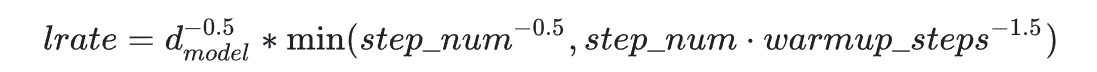

In [ ]:

class CustomSchedule(torch.optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        def lr_lambda(step):
          step = step + 1e-9
          return (d_model ** -0.5) * min(step ** -0.5, step  * (warmup_steps ** -1.5))
        super().__init__(optimizer, lr_lambda)


optimizer = torch.optim.Adam(model.parameters() , lr = 1e-3)

# Create the CustomSchedule
custom_schedule = CustomSchedule(optimizer, d_model=512, warmup_steps=4000)


In [ ]:
NEG_INFTY = -1e9

def create_masks(eng_batch, ta_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      eng_sentence_length, ta_sentence_length = len(eng_batch[idx]), len(ta_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
      ta_chars_to_padding_mask = np.arange(ta_sentence_length + 1, max_sequence_length)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, ta_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, ta_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, ta_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

## Training

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
train_data = CustomDataset(dataset)
x , y  = train_data[100]
print(f'English - {x}')
print(f'Tamil - {y} ')

English - they dont know it.
Tamil - அவர்களுக்கு அவரைத் தெரியாது. 


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size)


In [ ]:
device =  get_device()
model.train()
model.to(device)
total_loss = 0
num_epochs = 15

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    for batch_num, batch in enumerate(iterator):
        model.train()
        eng_batch, tamil_batch = batch
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, tamil_batch)
        optimizer.zero_grad()
        tamil_predictions = model(eng_batch,
                                     tamil_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)
        labels = model.decoder.sentence_embedding.batch_tokenize(tamil_batch, start_token=False, end_token=True)
        loss = criterian(
            tamil_predictions.view(-1, tamil_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == tamil_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optimizer.step()
        #train_losses.append(loss.item())
        if batch_num % 2000 == 0 and batch_num != 0 :
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"tamil Translation: {tamil_batch[0]}")
            tamil_sentence_predicted = torch.argmax(tamil_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in tamil_sentence_predicted:
              if idx == tamil_to_index[END_TOKEN]:
                break
              predicted_sentence += index_to_tamil[idx.item()]
            print(f"tamil Prediction: {predicted_sentence}")


            model.eval()
            tamil_sentence = ("",)
            eng_sentence = ("evaluation translation (should we go to the mall?",)
            for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, tamil_sentence)
                predictions = model(eng_sentence,
                                          tamil_sentence,
                                          encoder_self_attention_mask.to(device),
                                          decoder_self_attention_mask.to(device),
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = index_to_tamil[next_token_index]
                tamil_sentence = (tamil_sentence[0] + next_token, )
                if next_token == END_TOKEN:
                  break

            print(f"Evaluation translation (should we go to the mall?) : {tamil_sentence}")
            print("-------------------------------------------")

Epoch 0
Iteration 2000 : 5.552769184112549
English: lets start from here.
tamil Translation: இங்கிருந்து தொடங்கிடுவோம்
tamil Prediction: ஈஈஈ9ஈ1ஈஈஈஈஈஈஈ௬ஈ8ஈஈஈஈஈஈஈ9ஈPஈஈஈஈஈஈஈஈஈ9ஈஈஈ9ஈஈ8ஈஈஈஈஈஈ""ஈஈஈ௬ஈ"ஈ99:ஈ8ஈஈஈஈஈஈஈ"ஈஈஈஈஈஈஈஈஈஈஈஈ:ஈபஈஈஈஜஈஈஈ:ஈஈஈஈூ::ஈஈஈஈஈஈஈஈஈ19ஈஈஈஈஈஈஈஈஈ:ஈஈ1ஈஈஈபஈஈ8ஈஈஈஈ"ஈஈ:ூஈஈஈஈஈஈ=ஈஈ1௲=ஈஈஈஈஈஈ:98ஈஈஈஈலஈஈஈஈ"=பூஈஈஈஈபஈஈஈஈஈஈ":ஈPஈஈஈஈஈஈ"ஈ":ஈ(ஈூஈஈஈ:ஈPஈஈஈஈஈஈஈஈஈஈ
Evaluation translation (should we go to the mall?) : ('ஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈஈ',)
-------------------------------------------
Iteration 4000 : 5.575329303741455
English: dont give up!
tamil Translation: புடிச்சா விடாது!
tamil Prediction: ஈல"ஈ:ஈஈஈலஈஈஈஈஈஈஈஈஈ:ஈஈஈஈ"பஈஈ"ஈஈஈஈஜ":8ஈஈூ௬ஈ9ஈஈஈஈஈஈஈஈஈஈஈ8ஈஈ9ஈஈஈ:பஈஈஈஈஈபஈபஈ9ஈஈஈஈஈஈஈஈஈஈஈ௬ஈஈலஈஈஈஈஈஈஈஈஈ:லஈஈஈபஈஈஈஈஈஈஈஈஈஈ8ஈப9:ஈ௬ஈஈபஈஈஈஈஈஈஈஈஈ௲பஈஈ:ஈஈஈஈபஈஈஈஈபஈஈ8ஈஈஈஈ99ூ௲ஈஈஈஈஈ"ஈஈ:ஈஈப:1ஈஈ:ஈஈஈஈலஈஈப9ஈ1ஈஈஈபஈஈஈஈஈூபூ"பஈஈ8ஈ9ஈஈஈ

### Unfortunately it seems training for letter to letter model leads to trivial underfitting and predicting one letter for all
